Структура MobileNet

Слева нарисован блок обычной сверточной сети, а справа — базовый блок MobileNet.
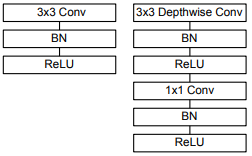


Сверточная часть интересующей нас сети состоит из одного обычного свёрточного слоя с 3х3 свёрткой в начале и тринадцати блоков, изображенных справа на рисунке, с постепенно увеличивающимся числом фильтров и понижающейся пространственной размерностью тензора.

Особенностью данной архитектуры является отсутствие max pooling-слоёв. Вместо них для снижения пространственной размерности используется свёртка с параметром stride, равным 2.

Двумя гиперпараметрами архитектуры MobileNet являются $\alpha$ (множитель ширины) и $\rho$ (множитель глубины или множитель разрешения).

Множитель ширины отвечает за количество каналов в каждом слое. Например, $\alpha = 1$ даёт нам архитектуру, описанную в статье, а $\alpha = 0.25$ — архитектуру с уменьшенным в четыре раза числом каналов на выходе каждого блока.

Множитель разрешения отвечает за пространственные размеры входных тензоров. Например, $\rho= 0.5$ означает, что высота и ширина feature map, подаваемой на вход каждому слою будет уменьшена вдвое.

Оба параметра позволяют варьировать размеры сети: уменьшая $\alpha$ и $\rho$, мы снижаем точность распознавания, но в то же время увеличиваем скорость работы и уменьшаем потребляемую память.



MobileNet v2
MobileNet v2 является улучшением версии v1. Структура v1 очень проста, но производительность невысока. Последующие серии ResNet, DenseNet и других структур доказали, что путем повторного использования функций изображений, использования Concat / Eltwise + и других операций для слияние может значительно улучшить сеть.
Кроме того, хотя Depthwise Conv сокращает объем вычислений, на практике многие ядра, обученные Depthwise после обучения, пусты, то есть, другими словами, возможно, что каждое ядро dim of Depthwise намного меньше обычного Conv. Под действием функции активации (ReLU) выход нейрона может легко стать 0.

In [ ]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

Загружаем данные

In [ ]:
!curl -L "https://public.roboflow.com/ds/SaiD62LBcH?key=PfMtXjx0gZ" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip
%cd /content/
%mkdir images/
%mv train images/train
%mv test images/test
%mv valid images/valid

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   889  100   889    0     0    936      0 --:--:-- --:--:-- --:--:--   935
100 60.9M  100 60.9M    0     0  21.0M      0  0:00:02  0:00:02 --:--:-- 50.5M
Archive:  roboflow.zip
 extracting: test/daisy/3699235066_fc09a02dfe_m_jpg.rf.083993c3ebd5cfdb89aef2abc23535fa.jpg  
 extracting: test/daisy/2579018590_74359dcf1a_m_jpg.rf.09c66018bd90f02891f966ce3d0c4c47.jpg  
 extracting: test/dandelion/3554435478_1a7ab743e9_n_jpg.rf.07d5667ff8bfd641e5004f6b2270d4b6.jpg  
 extracting: test/dandelion/34587720941_ccbbc420ec_n_jpg.rf.0adc605a005797e5ef3c26bd4c7078f9.jpg  
 extracting: test/daisy/22244161124_53e457bb66_n_jpg.rf.0647dd5bf7e8b1493bf4ab1aabe2df3e.jpg  
 extracting: test/daisy/6207492986_0ff91f3296_jpg.rf.03fc13bc6c049b950ab318b108e0283d.jpg  
 extracting: test/dandelion/8797114213_103535743c_m_jpg.rf.132646214f7e9bcbdda402ab688ca8

Преобразование данных в набор данных Tensorflow ImageFolder


Чтобы использовать классификационную сеть MobileNetV1, нам необходимо преобразовать наши загруженные данные в набор данных Tensorflow. Для этого Tensorflow Datasets предоставляет API ImageFolder, который позволяет вам использовать изображения из Roboflow напрямую с моделями, построенными в Tensorflow. Чтобы преобразовать наш набор данных в набор данных Tensorflow, мы можем сделать это:

Затем мы будем использовать конструктор для создания необработанных версий наших обучающих, тестовых и проверочных данных.

In [ ]:
import tensorflow_datasets as tfds
builder = tfds.folder_dataset.ImageFolder('images/')
print(builder.info)
raw_train = builder.as_dataset(split='train', shuffle_files=True)
raw_test = builder.as_dataset(split='test', shuffle_files=True)
raw_valid = builder.as_dataset(split='valid', shuffle_files=True)

tfds.core.DatasetInfo(
    name='image_folder',
    version=1.0.0,
    description='Generic image classification dataset.',
    homepage='https://www.tensorflow.org/datasets/catalog/image_folder',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    total_num_examples=1821,
    splits={
        'test': 182,
        'train': 1275,
        'valid': 364,
    },
    supervised_keys=('image', 'label'),
    citation="""""",
    redistribution_info=,
)



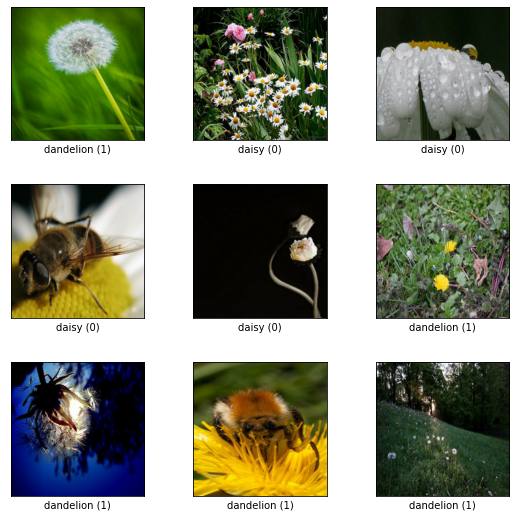

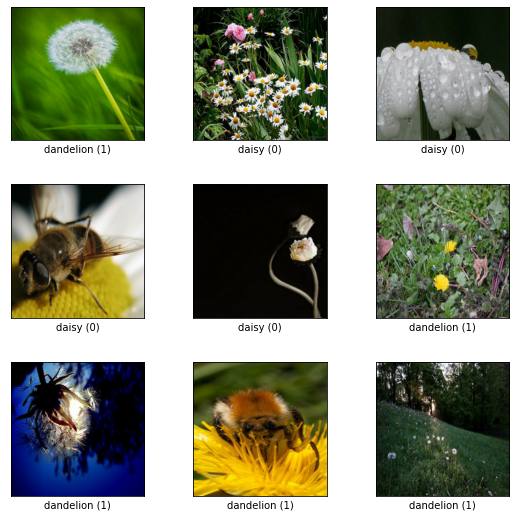

In [ ]:
tfds.show_examples(raw_train, builder.info)

Построение модели MobileNetV1

In [ ]:
import tensorflow.compat.v2 as tf

from keras import backend
from keras.applications import imagenet_utils
from keras.engine import training
from keras.layers import VersionAwareLayers
from keras.utils import data_utils
from keras.utils import layer_utils
from tensorflow.python.platform import tf_logging as logging
from tensorflow.python.util.tf_export import keras_export

BASE_WEIGHT_PATH = ('https://storage.googleapis.com/tensorflow/'
                    'keras-applications/mobilenet/')
layers = None


@keras_export('keras.applications.mobilenet.MobileNet',
              'keras.applications.MobileNet')
def MobileNet(input_shape=None,
              alpha=1.0,
              depth_multiplier=1,
              dropout=1e-3,
              include_top=True,
              weights='imagenet',
              input_tensor=None,
              pooling=None,
              classes=1000,
              classifier_activation='softmax',
              **kwargs):
  
  global layers
  if 'layers' in kwargs:
    layers = kwargs.pop('layers')
  else:
    layers = VersionAwareLayers()
  if kwargs:
    raise ValueError(f'Unknown argument(s): {(kwargs,)}')
  if not (weights in {'imagenet', None} or tf.io.gfile.exists(weights)):
    raise ValueError('The `weights` argument should be either '
                     '`None` (random initialization), `imagenet` '
                     '(pre-training on ImageNet), '
                     'or the path to the weights file to be loaded.  '
                     f'Received weights={weights}')

  if weights == 'imagenet' and include_top and classes != 1000:
    raise ValueError('If using `weights` as `"imagenet"` with `include_top` '
                     'as true, `classes` should be 1000.  '
                     f'Received classes={classes}')

  # правильнуя форма ввода и размер по умолчанию.
  if input_shape is None:
    default_size = 224
  else:
    if backend.image_data_format() == 'channels_first':
      rows = input_shape[1]
      cols = input_shape[2]
    else:
      rows = input_shape[0]
      cols = input_shape[1]

    if rows == cols and rows in [128, 160, 192, 224]:
      default_size = rows
    else:
      default_size = 224

  input_shape = imagenet_utils.obtain_input_shape(
      input_shape,
      default_size=default_size,
      min_size=32,
      data_format=backend.image_data_format(),
      require_flatten=include_top,
      weights=weights)

  if backend.image_data_format() == 'channels_last':
    row_axis, col_axis = (0, 1)
  else:
    row_axis, col_axis = (1, 2)
  rows = input_shape[row_axis]
  cols = input_shape[col_axis]

  if weights == 'imagenet':
    if depth_multiplier != 1:
      raise ValueError('If imagenet weights are being loaded, '
                       'depth multiplier must be 1.  '
                       'Received depth_multiplier={depth_multiplier}')

    if alpha not in [0.25, 0.50, 0.75, 1.0]:
      raise ValueError('If imagenet weights are being loaded, '
                       'alpha can be one of'
                       '`0.25`, `0.50`, `0.75` or `1.0` only.  '
                       f'Received alpha={alpha}')

    if rows != cols or rows not in [128, 160, 192, 224]:
      rows = 224
      logging.warning('`input_shape` is undefined or non-square, '
                      'or `rows` is not in [128, 160, 192, 224]. '
                      'Weights for input shape (224, 224) will be '
                      'loaded as the default.')

  if input_tensor is None:
    img_input = layers.Input(shape=input_shape)
  else:
    if not backend.is_keras_tensor(input_tensor):
      img_input = layers.Input(tensor=input_tensor, shape=input_shape)
    else:
      img_input = input_tensor

  x = _conv_block(img_input, 32, alpha, strides=(2, 2))
  x = _depthwise_conv_block(x, 64, alpha, depth_multiplier, block_id=1)

  x = _depthwise_conv_block(
      x, 128, alpha, depth_multiplier, strides=(2, 2), block_id=2)
  x = _depthwise_conv_block(x, 128, alpha, depth_multiplier, block_id=3)

  x = _depthwise_conv_block(
      x, 256, alpha, depth_multiplier, strides=(2, 2), block_id=4)
  x = _depthwise_conv_block(x, 256, alpha, depth_multiplier, block_id=5)

  x = _depthwise_conv_block(
      x, 512, alpha, depth_multiplier, strides=(2, 2), block_id=6)
  x = _depthwise_conv_block(x, 512, alpha, depth_multiplier, block_id=7)
  x = _depthwise_conv_block(x, 512, alpha, depth_multiplier, block_id=8)
  x = _depthwise_conv_block(x, 512, alpha, depth_multiplier, block_id=9)
  x = _depthwise_conv_block(x, 512, alpha, depth_multiplier, block_id=10)
  x = _depthwise_conv_block(x, 512, alpha, depth_multiplier, block_id=11)

  x = _depthwise_conv_block(
      x, 1024, alpha, depth_multiplier, strides=(2, 2), block_id=12)
  x = _depthwise_conv_block(x, 1024, alpha, depth_multiplier, block_id=13)

  if include_top:
    x = layers.GlobalAveragePooling2D(keepdims=True)(x)
    x = layers.Dropout(dropout, name='dropout')(x)
    x = layers.Conv2D(classes, (1, 1), padding='same', name='conv_preds')(x)
    x = layers.Reshape((classes,), name='reshape_2')(x)
    imagenet_utils.validate_activation(classifier_activation, weights)
    x = layers.Activation(activation=classifier_activation,
                          name='predictions')(x)
  else:
    if pooling == 'avg':
      x = layers.GlobalAveragePooling2D()(x)
    elif pooling == 'max':
      x = layers.GlobalMaxPooling2D()(x)

  # Ensure that the model takes into account
  # any potential predecessors of `input_tensor`.
  if input_tensor is not None:
    inputs = layer_utils.get_source_inputs(input_tensor)
  else:
    inputs = img_input

  # создание модели
  model = training.Model(inputs, x, name='mobilenet_%0.2f_%s' % (alpha, rows))

  # загружаем веса
  if weights == 'imagenet':
    if alpha == 1.0:
      alpha_text = '1_0'
    elif alpha == 0.75:
      alpha_text = '7_5'
    elif alpha == 0.50:
      alpha_text = '5_0'
    else:
      alpha_text = '2_5'

    if include_top:
      model_name = 'mobilenet_%s_%d_tf.h5' % (alpha_text, rows)
      weight_path = BASE_WEIGHT_PATH + model_name
      weights_path = data_utils.get_file(
          model_name, weight_path, cache_subdir='models')
    else:
      model_name = 'mobilenet_%s_%d_tf_no_top.h5' % (alpha_text, rows)
      weight_path = BASE_WEIGHT_PATH + model_name
      weights_path = data_utils.get_file(
          model_name, weight_path, cache_subdir='models')
    model.load_weights(weights_path)
  elif weights is not None:
    model.load_weights(weights)

  return model


def _conv_block(inputs, filters, alpha, kernel=(3, 3), strides=(1, 1)):
  
  channel_axis = 1 if backend.image_data_format() == 'channels_first' else -1
  filters = int(filters * alpha)
  x = layers.Conv2D(
      filters,
      kernel,
      padding='same',
      use_bias=False,
      strides=strides,
      name='conv1')(inputs)
  x = layers.BatchNormalization(axis=channel_axis, name='conv1_bn')(x)
  return layers.ReLU(6., name='conv1_relu')(x)


def _depthwise_conv_block(inputs,
                          pointwise_conv_filters,
                          alpha,
                          depth_multiplier=1,
                          strides=(1, 1),
                          block_id=1):
  
  channel_axis = 1 if backend.image_data_format() == 'channels_first' else -1
  pointwise_conv_filters = int(pointwise_conv_filters * alpha)

  if strides == (1, 1):
    x = inputs
  else:
    x = layers.ZeroPadding2D(((0, 1), (0, 1)), name='conv_pad_%d' % block_id)(
        inputs)
  x = layers.DepthwiseConv2D((3, 3),
                             padding='same' if strides == (1, 1) else 'valid',
                             depth_multiplier=depth_multiplier,
                             strides=strides,
                             use_bias=False,
                             name='conv_dw_%d' % block_id)(
                                 x)
  x = layers.BatchNormalization(
      axis=channel_axis, name='conv_dw_%d_bn' % block_id)(
          x)
  x = layers.ReLU(6., name='conv_dw_%d_relu' % block_id)(x)

  x = layers.Conv2D(
      pointwise_conv_filters, (1, 1),
      padding='same',
      use_bias=False,
      strides=(1, 1),
      name='conv_pw_%d' % block_id)(
          x)
  x = layers.BatchNormalization(
      axis=channel_axis, name='conv_pw_%d_bn' % block_id)(
          x)
  return layers.ReLU(6., name='conv_pw_%d_relu' % block_id)(x)


@keras_export('keras.applications.mobilenet.preprocess_input')
def preprocess_input(x, data_format=None):
  return imagenet_utils.preprocess_input(x, data_format=data_format, mode='tf')


@keras_export('keras.applications.mobilenet.decode_predictions')
def decode_predictions(preds, top=5):
  return imagenet_utils.decode_predictions(preds, top=top)


Отформатируем данные
Мы можем использовать модуль tf.image для форматирования изображений для задачи.

In [ ]:
IMG_SIZE = 160 # All images will be resized to 160x160

def format_example(pair):
  image, label = pair['image'], pair['label']
  image = tf.cast(image, tf.float32)
  image = (image/127.5) - 1
  image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
  return image, label

In [ ]:
train = raw_train.map(format_example)
validation = raw_valid.map(format_example)
test = raw_test.map(format_example)

In [ ]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

In [ ]:
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

In [ ]:
for image_batch, label_batch in train_batches.take(1):
   pass

image_batch.shape

TensorShape([32, 160, 160, 3])

создаем базовую модель

In [ ]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Create the base model from the pre-trained model MobileNet V1
base_model = MobileNet(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

17235968/17225924 [==============================] - 1s 0us/step


преобразуем каждое изображение 160x160x3

In [ ]:
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1024)


Извлечение признаков
На этом шаге замораживаем сверточную базу, созданную на предыдущем шаге, и будем использовать ее в качестве средства извлечения признаков. Кроме того, добавляем поверх него классификатор и обучаете классификатор верхнего уровня.

Заморозить сверточную базу
Перед компиляцией и обучением модели важно заморозить сверточную базу. Замораживание (путем установки layer.trainable = False) предотвращает обновление весов в данном слое во время обучения. MobileNet V1 имеет много слоев, поэтому установка флага обучаемости всей модели на False заморозит все слои.

In [ ]:
base_model.trainable = False

In [ ]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenet_1.00_160"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 80, 80, 32)        864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 80, 80, 32)       128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 80, 80, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 80, 80, 32)       288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 80, 80, 32)       128       
 ation)                                         

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1024)


In [ ]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


Теперь складываем экстрактор признаков и эти два слоя, используя модель tf.keras.Sequential:

In [ ]:
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

компилируем модель

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_160 (Functio  (None, 5, 5, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1)                 1025      
                                                                 
Total params: 3,229,889
Trainable params: 1,025
Non-trainable params: 3,228,864
_________________________________________________________________


3,2 млн параметров в MobileNet заморожены, но на уровне плотности есть 1к обучаемых параметров. Они разделены между двумя tf.Variable объектами, весами и смещениями.

In [ ]:
len(model.trainable_variables)

2

Обучение модели
После тренировки в течение 20 эпох точность должна быть высокой.

In [ ]:
initial_epochs = 20
validation_steps=20

loss0,accuracy0 = model.evaluate(validation_batches, steps = validation_steps)

12/20 [=================>............] - ETA: 0s - loss: 0.9604 - accuracy: 0.3764WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 20 batches). You may need to use the repeat() function when building your dataset.


20/20 [==============================] - 3s 83ms/step - loss: 0.9604 - accuracy: 0.3764


In [ ]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.96
initial accuracy: 0.38


In [ ]:
history = model.fit(train_batches,
                    epochs=initial_epochs,
                    validation_data=validation_batches)

Epoch 1/20
40/40 [==============================] - 9s 103ms/step - loss: 0.8177 - accuracy: 0.4627 - val_loss: 0.7499 - val_accuracy: 0.5330
Epoch 2/20
40/40 [==============================] - 7s 95ms/step - loss: 0.6745 - accuracy: 0.5867 - val_loss: 0.6222 - val_accuracy: 0.6484
Epoch 3/20
40/40 [==============================] - 7s 94ms/step - loss: 0.5673 - accuracy: 0.6894 - val_loss: 0.5238 - val_accuracy: 0.7308
Epoch 4/20
40/40 [==============================] - 6s 93ms/step - loss: 0.4858 - accuracy: 0.7686 - val_loss: 0.4502 - val_accuracy: 0.7885
Epoch 5/20
40/40 [==============================] - 7s 93ms/step - loss: 0.4252 - accuracy: 0.8078 - val_loss: 0.3969 - val_accuracy: 0.7995
Epoch 6/20
40/40 [==============================] - 6s 89ms/step - loss: 0.3781 - accuracy: 0.8337 - val_loss: 0.3546 - val_accuracy: 0.8352
Epoch 7/20
40/40 [==============================] - 7s 92ms/step - loss: 0.3426 - accuracy: 0.8533 - val_loss: 0.3244 - val_accuracy: 0.8654
Epoch 8/20
4

Кривые обучения
Посмотрим на кривые обучения точности / потери обучения и проверки при использовании базовой модели MobileNet V1

Чтобы оценить производительность модели во время обучения и проверки, мы можем построить график потерь и точности:

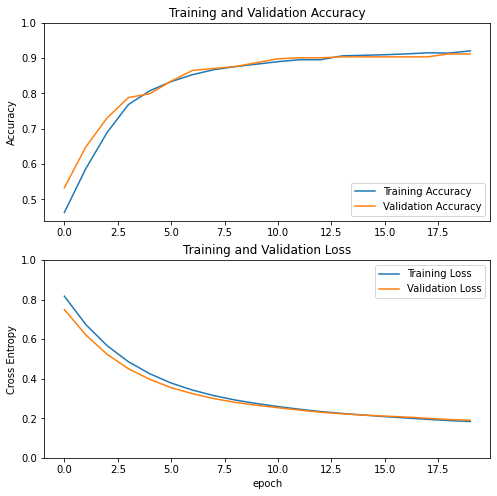

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Точная настройка модели
Для точной настройки модели нам сначала нужно разморозить базовую модель и заморозить все слои перед определенным слоем; в этом случае мы заморозим все слои до 100-го слоя:

In [ ]:
base_model.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# точная настройка с 100 слоя
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  86


In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_160 (Functio  (None, 5, 5, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1)                 1025      
                                                                 
Total params: 3,229,889
Trainable params: 1,025
Non-trainable params: 3,228,864
_________________________________________________________________


In [ ]:
len(model.trainable_variables)

2

дообучение модели еще 10 эпох

In [ ]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_batches,
                         epochs=total_epochs,
                         initial_epoch =  history.epoch[-1],
                         validation_data=validation_batches)

Epoch 20/30
40/40 [==============================] - 9s 113ms/step - loss: 0.1798 - accuracy: 0.9271 - val_loss: 0.1896 - val_accuracy: 0.9093
Epoch 21/30
40/40 [==============================] - 6s 89ms/step - loss: 0.1791 - accuracy: 0.9247 - val_loss: 0.1894 - val_accuracy: 0.9093
Epoch 22/30
40/40 [==============================] - 6s 90ms/step - loss: 0.1785 - accuracy: 0.9255 - val_loss: 0.1892 - val_accuracy: 0.9093
Epoch 23/30
40/40 [==============================] - 7s 96ms/step - loss: 0.1780 - accuracy: 0.9255 - val_loss: 0.1889 - val_accuracy: 0.9093
Epoch 24/30
40/40 [==============================] - 7s 93ms/step - loss: 0.1775 - accuracy: 0.9255 - val_loss: 0.1887 - val_accuracy: 0.9093
Epoch 25/30
40/40 [==============================] - 7s 93ms/step - loss: 0.1770 - accuracy: 0.9255 - val_loss: 0.1883 - val_accuracy: 0.9093
Epoch 26/30
40/40 [==============================] - 7s 93ms/step - loss: 0.1765 - accuracy: 0.9278 - val_loss: 0.1881 - val_accuracy: 0.9093
Epoch

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

попробуем вывести кривые после дообучения

и видим что точность повысилась,а потери уменьшились

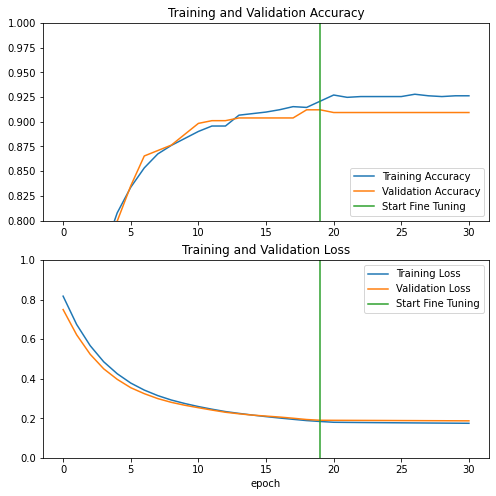

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Text(0.5, 1.0, 'Dandelion')

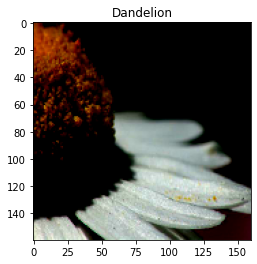

In [ ]:
test_batches = test.batch(1)
for image, label in test_batches.take(1):
  pass
plt.imshow(np.squeeze(image))
plt.title("Dandelion" if model.predict(image) > 0 else "Daisy")